Kütüphanelerin Yüklenmesi


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Layer, Dropout, BatchNormalization



from sklearn.model_selection import GridSearchCV  # Hiper parametrelerin optimizasyonu icin kullandik.

# RBF icin kullaniyoruz.
#from keras.datasets import cifar10
from keras.optimizers import Adam
import tensorflow.keras.backend as K

Verilerin Yüklenmesi

In [6]:
# Adım 2: CIFAR-10 Veri Setinin Yüklenmesi ve Ön İşleme
# Veri Yükleme
# CIFAR-10 veri setini TensorFlow/Keras kullanarak yükleyebilirsiniz:



# CIFAR-10 veri setini yükle
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Sınıf isimlerini set et
class_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"
]

print(f"Train data shape: {x_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train data shape: (50000, 32, 32, 3), Train labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000, 1)


Veri Görselleştirme


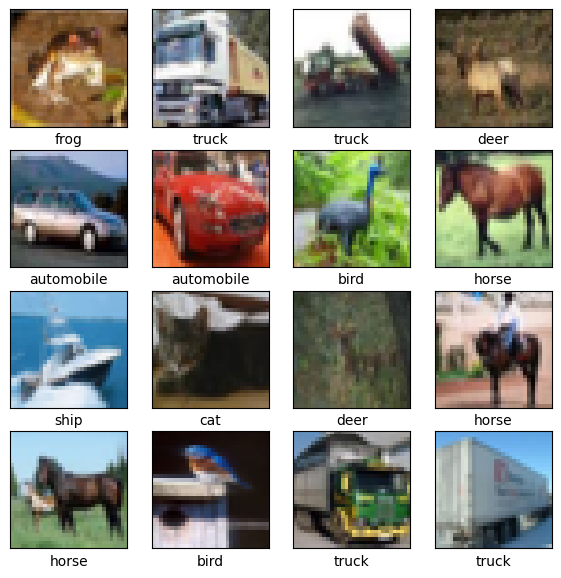

In [6]:
# Veri setini gorsellestir.
# Örnek görüntülerin görselleştirilmesi

plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

Eksik Veri Varmı


In [4]:
print(pd.DataFrame(x_train.reshape(-1, 3072)).isnull().sum().sum())

0


Veri Setini Ayarlama


In [7]:
# Veri setinin train ve test olarak bolunmesi.
# Eğitim Verisi (x_train_split, y_train_split): Modeli eğitmek için kullanılır (%80).
# Doğrulama Verisi (x_test_split, y_test_split): Modeli test etmek ve optimize etmek için kullanılır (%20).
# train_test_split : scikit-learn kutuphanesindekki fonksiyon veriyi test ve egitim kumelerine ayırır.
# test_size : veriyi boldugumuz yuzdesel orandir. (%20 test, %80 train gibi)
# random_state : Veriyi bölme işlemini tekrar üretilebilir hale getirmek için kullanılan bir sabittir. Aynı sabit değer kullanıldığında bölme her seferinde aynı sonuçları verir
# Varsayılan olarak None bırakılırsa, her çalıştırmada rastgele bir bölme yapılır. (random_state=None)


# Eğitim ve test verilerini %80 - %20 oranında ayırma
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Eğitim veri şekli:", x_train_split.shape, y_train_split.shape)
print("Doğrulama veri şekli:", x_test_split.shape, y_test_split.shape)

Eğitim veri şekli: (40000, 32, 32, 3) (40000, 1)
Doğrulama veri şekli: (10000, 32, 32, 3) (10000, 1)


Özellik Ölçekleme (Feature Scaling

In [7]:
# Sınıfları ve Hedef İsimleri Doğrulayın: Modelin tahmin ettiği sınıflar ile class_names listesindeki sınıfların sayısını ve isimlerini karşılaştırın.
# print("Unique classes in predictions:", set(y_pred_rbf_classes))
# print("Number of target names:", len(class_names))
# print("Target names:", class_names)

In [9]:
 # 2.4 Özellik Ölçekleme
# CIFAR-10 veri setini MLP ve RBF modellerine uygun hale getirmek için verileri normalleştirip
# Sinir ağlarının daha iyi çalışması için veriler normalize edilmelidir:
# RGB piksel değerleri [0, 255] aralığından [0, 1] aralığına ölçeklendirilir.
# Etiketler bir-hot encoding formatına dönüştürülür.

# Görüntüleri 0-1 aralığına ölçeklendirme
x_train = x_train.astype('float32') / 255.0    # Normalize images
x_test = x_test.astype('float32') / 255.0       # Normalize images



# reshape metodu, çok boyutlu veri yapısını düz bir vektör haline getiriyor (flattening).
# birçok makine öğrenimi algoritması yalnızca düz (1D) vektörler ile çalışır
# X_train.shape[0]: Eğitim setindeki örneklerin (resimlerin) sayısını belirtir.
# -1 : her bir örneğin (ör. bir resim) düzleştirildiğinde kaç elemandan oluşacağını otomatik olarak belirler.

### Görüntüleri vektör hale getirme (MLP için gerekli)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

### Etiketleri one-hot encoding yapma (RBF için gerekli)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)


# Standardize the data
# Bu adımda veriler standardize ediliyor. Yani, her özelliğin (piksel değerlerinin) ortalaması 0, standart sapması ise 1 olacak şekilde ölçekleniyor.
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat) # Hem öğrenme (fit), hem dönüştürme (transform) işlemi aynı anda yapılır.
x_test_scaled = scaler.transform(x_test_flat) # Test seti, eğitim setinden hesaplanan ortalama ve standart sapma değerlerini kullanarak standardize edilir.
                                              #Test setinde hiçbir şekilde fit işlemi yapılmaz; yalnızca transform uygulanır.

# Çoğu makine öğrenimi algoritması, veriyi matris yerine düz vektörler halinde bekler.
# Özellikle, lojistik regresyon, SVM, veya basit sinir ağları gibi algoritmalarda bu işlem şarttır.

MLP Modeli Eğitimi

In [ ]:
begin_time = time.time()

# Adım 3.1: MLP Modelinin Eğitimi
# MLP Modeli Oluşturma
# Sklearn'den MLPClassifier kullanarak bir MLP modeli tanımlayabilirsiniz. Aşağıdaki kod, temel bir MLP modelini eğitmek içindir:

# MLP modelini oluşturma, Sonrasinda bu parametreler ile optimizasyon yapilacak
mlp_model = MLPClassifier(
    hidden_layer_sizes=(200, 200, 50), # Gizli katmanlar ve nöron sayıları. # Configurations of hidden layers and their neuron counts.
                                  # # Examples: (50,) means one hidden layer with 50 neurons; (200, 200) means two hidden layers with 100 neurons each.
                                  # 1.Layer:200, 2.LAyer: 200, Nerons:50
    activation='logistic',           # Aktivasyon fonksiyonu
    solver='adam',               # Optimizasyon algoritması
    learning_rate_init=0.001,    # Öğrenme oranı, controls how fast or slow the model learns at each step.
    max_iter=500,                 # Maksimum iterasyon, ayni zamanda EPOCS ile aynidir. early_stopping kullandigimiz icin egitime gereksiz oldugunda devam etmeyecektir.
    alpha= 0.01,  # L2 düzenleme parametresi, aşırı uyumu onlemek icin penalty olarak kullanilir.
    random_state=42,
    early_stopping=True,   # Early stopping'i etkinleştiriyoruz.(Stops training when validation performance no longer improves.,
                          # This helps prevent overfitting and reduces unnecessary computation.)
    validation_fraction= 0.2  # Doğrulama seti oranı, Reserves 20% of the training data as a validation set for early stopping
)

# Modeli eğitme
mlp_model.fit(x_train_scaled, y_train.ravel())

# Modelin tahmin yapması
y_pred_mlp = mlp_model.predict(x_test_scaled)

# MLP Test Doğruluk Oranı
mlp_test_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Test Accuracy: {mlp_test_accuracy:.4f}")

end_time = time.time()

elapsed_time = end_time - begin_time

print(f"Elapsed time: {elapsed_time:.5f} seconds")

MLP Test Accuracy: 0.4573
Elapsed time: 62.35933 seconds


RBF MODELİ



In [ ]:
# Keras, Dense katmanında yerleşik olarak bir "RBF" veya "Gaussian" aktivasyon fonksiyonu sunmaz.
#Bunun yerine, Gaussian tabanlı bir aktivasyon fonksiyonu tanımlamanız gerekiyor.
class RBF(Layer):
    def __init__(self, beta=1.0, **kwargs):
        super(RBF, self).__init__(**kwargs)
        self.beta = beta

    def call(self, inputs):
        return K.exp(-self.beta * K.square(inputs))

# Kayıt işlemi (opsiyonel)
tf.keras.utils.get_custom_objects().update({'rbf': RBF()})
from tensorflow.keras.regularizers import l2
# 3.2. RBF Modeli:
#     ◦ sklearn kütüphanesinde doğrudan RBF modeli bulunmadığından, KEras kütüphanesi kullanın
#     ◦ Alternatif olarak, rbfnetwork gibi özel kütüphaneler veya Python’da yazılmış RBF fonksiyonları kullanılabilir.

rbf_model = Sequential([
    Input(shape=(32, 32, 3)),
    Flatten(),

    # Layer 1
    Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 2
    Dense(512, activation=RBF(beta=0.5), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Layer 3
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer
    Dense(10, activation='softmax')  # 10 classes for CIFAR-10 dataset
])

rbf_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = rbf_model.fit(x_train, y_train, epochs=30, batch_size=64,  validation_data=(x_test, y_test))
# batch-size : xperiment with different batch sizes (32, 64, 128). Smaller batch sizes can provide a more stochastic training process, which can help escape local minima, but can also lead to noisy training.



Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1724 - loss: 26.0262 - val_accuracy: 0.2722 - val_loss: 19.2895
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2729 - loss: 17.7281 - val_accuracy: 0.3538 - val_loss: 12.9821
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3298 - loss: 11.9686 - val_accuracy: 0.2831 - val_loss: 9.0806
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3601 - loss: 8.1458 - val_accuracy: 0.3560 - val_loss: 6.2577
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3794 - loss: 5.7220 - val_accuracy: 0.3583 - val_loss: 4.5852
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3900 - loss: 4.2433 - val_accuracy: 0.3548 - val_loss: 3.6580
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4058 - loss: 3.3277 - val_accuracy: 0.3730 - val_loss: 3.0073
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4120 - loss: 2.7737 - val_accura

 MLP Confusion Matrix


In [ ]:
# # 4.1  Karışıklık Matrisi Görselleştirme
# Karışıklık matrisi oluşturma
def mlp_confisuon_matrix_visual():
  conf_matrix = confusion_matrix(y_test, y_pred_mlp)
  # Görselleştirme
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.title("MLP Model Confisuon Matrisi")
  plt.xlabel("Tahmin Edilen")
  plt.ylabel("Gerçek")
  plt.show()

RBF Confusion Matrix


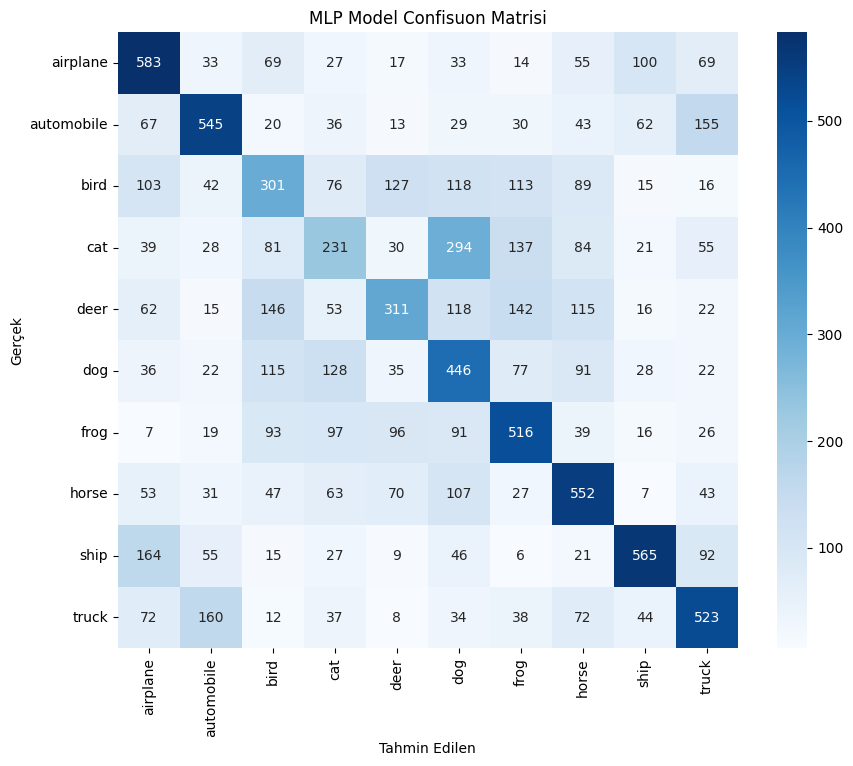

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


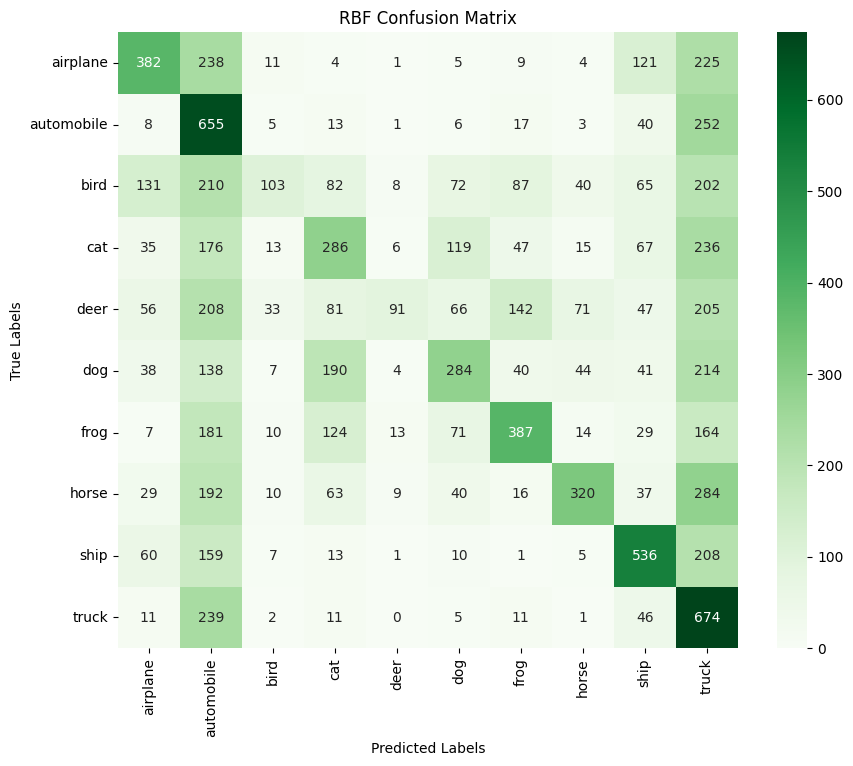

In [ ]:
# RBF icin confusion matrix
# Tahminlerde bulun
def rbf_confisuon_matrix_visual():
  y_pred_probs = rbf_model.predict(x_test)  # Tahmin edilen olasılıklar
  y_pred = np.argmax(y_pred_probs, axis=1)  # En yüksek olasılıklı sınıfı seç

  # Confusion matrix oluştur
  cm = confusion_matrix(y_test, y_pred)

  # Confusion matrix'i görselleştir
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('RBF Confusion Matrix')
  plt.show()

mlp_confisuon_matrix_visual()
rbf_confisuon_matrix_visual()

MLP Performance Tahminleri

In [ ]:
 # 4.2 Performans Metrikleri: Accuracy, Precision, Recall, F1-Score
# MLP modelinin doğruluk, hassasiyet (precision), geri çağırma (recall) ve F1 skoru gibi metriklerini hesaplamak için classification_report fonksiyonunu kullanabilirsiniz:


# MLP model performansı
print("MLP Model Performans Metrikleri:")
print(classification_report(y_test, y_pred_mlp, target_names=class_names))


# Classification report verilerini tabloya dönüştürme
report_mlp = classification_report(y_test, y_pred_mlp, target_names=class_names, output_dict=True)
df_report_mlp = pd.DataFrame(report_mlp).transpose()
print(df_report_mlp)

MLP Model Performans Metrikleri:
              precision    recall  f1-score   support

    airplane       0.49      0.58      0.53      1000
  automobile       0.57      0.55      0.56      1000
        bird       0.33      0.30      0.32      1000
         cat       0.30      0.23      0.26      1000
        deer       0.43      0.31      0.36      1000
         dog       0.34      0.45      0.39      1000
        frog       0.47      0.52      0.49      1000
       horse       0.48      0.55      0.51      1000
        ship       0.65      0.56      0.60      1000
       truck       0.51      0.52      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.45     10000
weighted avg       0.46      0.46      0.45     10000

              precision  recall  f1-score     support
airplane       0.491568  0.5830  0.533394   1000.0000
automobile     0.573684  0.5450  0.558974   1000.0000
bird           0.334816  0.3010  0.317009   10

 RBF Performance Tahminleri

In [ ]:
# Test seti üzerinde tahmin yap
y_pred_rbf = rbf_model.predict(x_test)
y_pred_rbf_classes = y_pred_rbf.argmax(axis=1)  # One-hot encoding yerine sınıf etiketlerini al

# Performans değerlendirmesi
from sklearn.metrics import classification_report, accuracy_score

print("RBF Model Performansı:")
print(classification_report(y_test, y_pred_rbf_classes, target_names=class_names))

# RBF Test Doğruluk Oranı
rbf_test_accuracy = accuracy_score(y_test, y_pred_rbf_classes)
print(f"RBF Test Accuracy: {rbf_test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RBF Model Performansı:
              precision    recall  f1-score   support

    airplane       0.54      0.51      0.53      1000
  automobile       0.47      0.68      0.56      1000
        bird       0.39      0.20      0.26      1000
         cat       0.39      0.19      0.25      1000
        deer       0.40      0.26      0.32      1000
         dog       0.38      0.49      0.43      1000
        frog       0.40      0.67      0.50      1000
       horse       0.44      0.59      0.51      1000
        ship       0.65      0.39      0.49      1000
       truck       0.48      0.52      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.46      0.45      0.43     10000
weighted avg       0.46      0.45      0.43     10000

RBF Test Accuracy: 0.4503


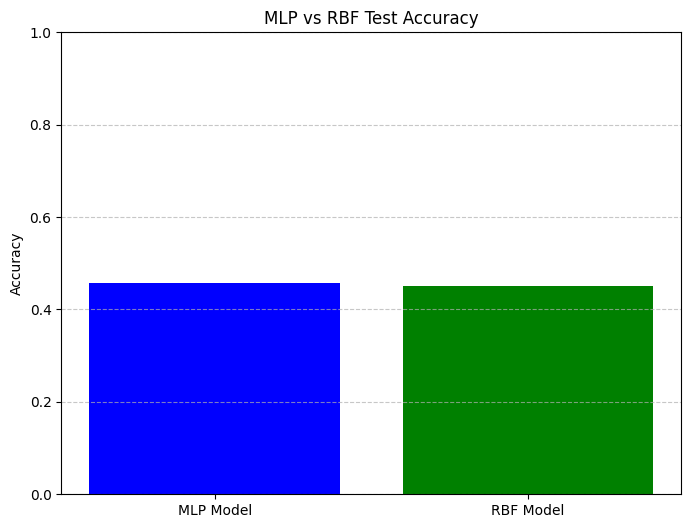

In [ ]:
# MLP ve RBF doğruluk oranları
model_names = ["MLP Model", "RBF Model"]
accuracies = [mlp_test_accuracy, rbf_test_accuracy]

# Grafik çizimi
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # Y eksenini 0-1 aralığında sınırla
plt.ylabel("Accuracy")
plt.title("MLP vs RBF Test Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Hiperparametre Denemeleri


In [ ]:
#from sklearn.model_selection import GridSearchCV

# Hiperparametre aralığı
param_grid = {
    'hidden_layer_sizes': [(128,), (128, 64), (256, 128), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001],
}

# GridSearchCV ile en iyi parametreleri bulma
grid_search_mlp = GridSearchCV(
    estimator=MLPClassifier(max_iter=100, early_stopping=True, validation_fraction=0.2, random_state=42),
    param_grid=param_grid,
    cv=3,  # 3 katlı çapraz doğrulama
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Eğitim
grid_search_mlp.fit(x_train_scaled, y_train.ravel())

# En iyi parametreler ve performans
print("En İyi Parametreler (MLP):", grid_search_mlp.best_params_)
print("En İyi Çapraz Doğrulama Skoru:", grid_search_mlp.best_score_)

# En iyi model ile test doğruluğu
best_mlp_model = grid_search_mlp.best_estimator_
test_accuracy_mlp = best_mlp_model.score(x_test_scaled, y_test)
print(f"Test Doğruluğu (MLP): {test_accuracy_mlp:.4f}")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
En İyi Parametreler (MLP): {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001, 'solver': 'sgd'}
En İyi Çapraz Doğrulama Skoru: 0.4921600019937679
Test Doğruluğu (MLP): 0.5039


In [10]:
#from sklearn.model_selection import GridSearchCV

# Hiperparametre aralığı
param_grid = {
    'hidden_layer_sizes': [(128,), (128, 64), (256, 128), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001],
}

# GridSearchCV ile en iyi parametreleri bulma
grid_search_mlp = GridSearchCV(
    estimator=MLPClassifier(max_iter=50, early_stopping=True, validation_fraction=0.2, random_state=39),
    param_grid=param_grid,
    cv=3,  # 3 katlı çapraz doğrulama
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Eğitim
grid_search_mlp.fit(x_train_scaled, y_train.ravel())

# En iyi parametreler ve performans
print("En İyi Parametreler (MLP):", grid_search_mlp.best_params_)
print("En İyi Çapraz Doğrulama Skoru:", grid_search_mlp.best_score_)

# En iyi model ile test doğruluğu
best_mlp_model = grid_search_mlp.best_estimator_
test_accuracy_mlp = best_mlp_model.score(x_test_scaled, y_test)
print(f"Test Doğruluğu (MLP): {test_accuracy_mlp:.4f}")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
En İyi Parametreler (MLP): {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001, 'solver': 'sgd'}
En İyi Çapraz Doğrulama Skoru: 0.496300005597152
Test Doğruluğu (MLP): 0.5147


In [11]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


RBF İçin Hiperparametre Denemeleri

In [ ]:
 from kerastuner.tuners import RandomSearch
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.layers import Dense, Flatten, Input
 from tensorflow.keras.optimizers import Adam

# Model oluşturucu fonksiyonu
def build_rbf_model(hp):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Flatten(),
        Dense(hp.Int('units_layer1', min_value=128, max_value=512, step=128), activation='relu'),
        Dense(hp.Int('units_layer2', min_value=64, max_value=256, step=64), activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# RandomSearch ile hiperparametre optimizasyonu
tuner = RandomSearch(
    build_rbf_model,
    objective='val_accuracy',
    max_trials=5,  # Denenecek hiperparametre kombinasyon sayısı
    executions_per_trial=1,
    directory='my_dir',
    project_name='rbf_tuning'
)

# Optimizasyonu çalıştırma
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=64)

# En iyi model ve hiperparametreler
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"En İyi Hiperparametreler: {best_hps.values}")

# En iyi modeli eğitme
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), batch_size=64)

# Test doğruluğu
test_accuracy_rbf = best_model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Test Doğruluğu (RBF): {test_accuracy_rbf:.4f}")

Reloading Tuner from my_dir/rbf_tuning/tuner0.json
En İyi Hiperparametreler: {'units_layer1': 512, 'units_layer2': 256, 'learning_rate': 0.0001}
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2993 - loss: 1.9535 - val_accuracy: 0.3930 - val_loss: 1.7104
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4118 - loss: 1.6818 - val_accuracy: 0.4177 - val_loss: 1.6403
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4368 - loss: 1.5872 - val_accuracy: 0.4402 - val_loss: 1.5696
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4633 - loss: 1.5271 - val_accuracy: 0.4673 - val_loss: 1.5187
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4789 - loss: 1.4852 - val_accuracy: 0.4669 - val_loss: 1.5081
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4902 - loss: 1.4445 - val_accuracy: 0.4637 - val_loss: 1.5024
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5015 - loss: 1.4057 -

In [12]:
 from kerastuner.tuners import RandomSearch
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.layers import Dense, Flatten, Input
 from tensorflow.keras.optimizers import Adam

# Model oluşturucu fonksiyonu
def build_rbf_model(hp):
    model = Sequential([
        Input(shape=(32, 32, 3)),
        Flatten(),
        Dense(hp.Int('units_layer1', min_value=128, max_value=400, step=128), activation='relu'),
        Dense(hp.Int('units_layer2', min_value=64, max_value=400, step=64), activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# RandomSearch ile hiperparametre optimizasyonu
tuner = RandomSearch(
    build_rbf_model,
    objective='val_accuracy',
    max_trials=5,  # Denenecek hiperparametre kombinasyon sayısı
    executions_per_trial=1,
    directory='my_dir',
    project_name='rbf_tuning'
)

# Optimizasyonu çalıştırma
tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)

# En iyi model ve hiperparametreler
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"En İyi Hiperparametreler: {best_hps.values}")

# En iyi modeli eğitme
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)

# Test doğruluğu
test_accuracy_rbf = best_model.evaluate(x_test, y_test, verbose=0)[1]
print(f"Test Doğruluğu (RBF): {test_accuracy_rbf:.4f}")

Trial 5 Complete [00h 00m 40s]
val_accuracy: 0.4715000092983246

Best val_accuracy So Far: 0.4851999878883362
Total elapsed time: 00h 03m 11s
En İyi Hiperparametreler: {'units_layer1': 128, 'units_layer2': 192, 'learning_rate': 0.0001}
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2812 - loss: 1.9923 - val_accuracy: 0.3741 - val_loss: 1.7571
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3869 - loss: 1.7307 - val_accuracy: 0.4048 - val_loss: 1.6676
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4199 - loss: 1.6362 - val_accuracy: 0.4334 - val_loss: 1.6111
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4407 - loss: 1.5862 - val_accuracy: 0.4372 - val_loss: 1.6014
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4619 - loss: 1.5275 - val_accuracy: 0.4575 - val_loss: 1.5359
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4714 - loss: 1.5051 - val_accuracy: 0.4610 - v

 Sonuçları Karşılaştırma ve Yorumlama

In [14]:
results = {
    "Model": ["MLP", "RBF"],
    "Best Hyperparameters": [grid_search_mlp.best_params_, best_hps.values],
    "Test Accuracy": [test_accuracy_mlp, test_accuracy_rbf]
}

#import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

  Model                               Best Hyperparameters  Test Accuracy
0   MLP  {'activation': 'relu', 'alpha': 0.0001, 'hidde...         0.5147
1   RBF  {'units_layer1': 128, 'units_layer2': 192, 'le...         0.4800
